In [1]:
%%time

import os
import csv
import pandas as pd

file_name = os.getenv('HOME')+'/aiffel/aeumgil/data/train_original.csv'
news = pd.read_csv(file_name)

CPU times: user 13.3 s, sys: 1.21 s, total: 14.5 s
Wall time: 14.2 s


<string>:2: DtypeWarning: Columns (0,6,10) have mixed types.Specify dtype option on import or set low_memory=False.


In [2]:
news = news.drop(news.index[0])
news.head()

,id,category,media_type,media_sub_type,media_name,size,char_count,publish_date,title,text,annotator_id,document_quality_scores,extractive,abstractive
1,290741778,종합,online,지역지,광양신문,small,927,2018-01-05 18:54:55,"논 타작물 재배, 2월 말까지 신청하세요","[[{'index': 0, 'sentence': 'ha당 조사료 400만원…작물별 ...",11,"{'readable': 4, 'accurate': 3, 'informative': ...","[2, 3, 10]","[""전라남도가 쌀 과잉문제를 근본적으로 해결하기 위해 올해부터 벼를 심었던 논에 벼..."
2,290741792,종합,online,지역지,광양신문,small,764,2018-01-05 18:53:20,"여수시, 컬러빌리지 마무리...‘색채와 빛’도시 완성","[[{'index': 0, 'sentence': '8억 투입, 고소천사벽화·자산마을...",12,"{'readable': 4, 'accurate': 4, 'informative': ...","[2, 4, 11]",['여수시는 컬러빌리지 사업에 8억원을 투입하여 ‘색채와 빛’ 도시를 완성하여 고소...
3,290741793,스포츠,online,지역지,광양신문,medium,1066,2018-01-05 18:52:15,“새해 정기 받고 올해는 반드시 일내자!”,"[[{'index': 0, 'sentence': '전남드래곤즈 해맞이 다짐…선수 영...",13,"{'readable': 4, 'accurate': 4, 'informative': ...","[3, 5, 7]",['전남드래곤즈 임직원과 선수단이 4일 구봉산 정상에 올라 일출을 보며 2018년 ...
4,290741794,정치,online,지역지,광양신문,small,746,2018-01-05 18:50:17,"농업인 역량 강화, 새해 실용교육 실시","[[{'index': 0, 'sentence': '11~24일, 매실·감·참다래 등...",12,"{'readable': 4, 'accurate': 4, 'informative': ...","[2, 3, 4]","['광양시는 농업인들의 경쟁력을 높이고, 소득안정을 위해 매실·감·참다래 등 지역특..."
5,290741797,종합,online,지역지,광양신문,small,978,2018-01-05 18:52:36,타이완 크루즈관광객 4천여명‘전남’온다,"[[{'index': 0, 'sentence': '홍콩 크루즈선사‘아쿠아리우스’ 4...",13,"{'readable': 4, 'accurate': 4, 'informative': ...","[3, 7, 4]",['올해 4월과 6월 두 차례에 걸쳐 타이완의 크루즈 관광객 4000여명이 여수에 ...


In [3]:
import ast
import datetime

def eval_(x): return ast.literal_eval(x)

def origin(x):
    '''
    text 컬럼에 mapping하여 원문을 반환하는 함수입니다.
    '''
    origin_txt = []
    for i in eval_(x):
        for j in i:
            origin_txt.append(j['sentence'])
    return origin_txt

def extract_sen(txt, ext):
    '''
    extractive 컬럼에 mapping하여 추출요약문 리스트를 반환하는 함수입니다.
    '''
    exts = []

    for i in eval_(txt) : 
        for j in (i):
            if j['index'] in eval_(ext): 
                exts.append(j['sentence'])
    return exts

def abstract_sen(x):
    '''
    abstractive 컬럼에 mapping하여 생성요약문을 추출하는 반환하는 함수입니다.
    '''
    return eval_(x)[0]

def score(x):
    '''
    document_quality_scores 컬럼에 mapping하여 readable, accurate, informative, trustworthy 를 반환하는 함수입니다.
    '''
    return eval_(x)['readable'], eval_(x)['accurate'], eval_(x)['informative'], eval_(x)['trustworthy']

def publish_date(x):
    '''
    publish_date 컬럼에 mapping하여 year, month, date 을 반환하는 함수입니다. 
    '''
    tmp = x.split()[0]
    date = datetime.datetime.strptime(tmp, "%Y-%m-%d")

    return date.year, date.month, date.day

In [4]:
%%time
news['origin'] = news['text'].map(lambda x : origin(x))
news['ext_sum'] = news.apply(lambda x : extract_sen(x['text'],x['extractive']), axis=1 )
news['abs_sum'] = news['abstractive'].map(lambda x : abstract_sen(x))

news['readable'] = news['document_quality_scores'].map(lambda x : score(x)[0])
news['accurate'] = news['document_quality_scores'].map(lambda x : score(x)[1])
news['informative'] = news['document_quality_scores'].map(lambda x : score(x)[2])
news['trustworthy'] = news['document_quality_scores'].map(lambda x : score(x)[3])

news['year'] = news['publish_date'].map(lambda x : publish_date(x)[0])
news['month'] = news['publish_date'].map(lambda x : publish_date(x)[1])
news['date'] = news['publish_date'].map(lambda x : publish_date(x)[2])

news['extractive'] = news['extractive'].apply(eval_)
news = news.astype({'char_count':'int'})

CPU times: user 4min 9s, sys: 3.49 s, total: 4min 12s
Wall time: 4min 12s


## Types of Features

### Categorical Feautures
- 'category' : 신문 기사의 주제 분류
- 'media_name' : 신문 매체의 이름 분류

### Ordinal Features
- 'size' : char_count에 따른 기사 크기 분류 (small, medium, big)
- 'readable' : 가독성에 따른 순서분류 (1-4)
- 'accurate' : 정확성에 따른 순서분류 (1-4)
- 'informative' : 정보량에 따른 순서분류 (1-4)
- 'trustworthy' : 신뢰성에 따른 순서분류 (1-4)

### Continuous Features
- 'year', 'month', 'date' : 년, 월, 시

In [5]:
%%capture
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [7]:
def pie_plot(df, col_name, prob=False):
    sns.set(rc = {'figure.figsize':(10,6)})
    plt.rc('font', family='NanumBarunGothic') 

    cnt = df[col_name].value_counts() 
    if prob:
        prob = cnt / cnt.sum()
        prob = prob[prob>0.01]
        cnt = prob

    plt.pie(cnt.values,labels = cnt.index.values, autopct='%.1f%%', pctdistance=0.8, explode=[0.05]*len(cnt),textprops={'fontsize': 14}, startangle=90)
    plt.title(col_name, fontsize=20)
    plt.show()

def count_plot(df, col_name, figsize=(8,4), rotation=True):
    sns.set(rc = {'figure.figsize': figsize})
    plt.rc('font', family='NanumBarunGothic') 
    sns.countplot(x=col_name, data=df)
    if rotation:
        plt.xticks(rotation=45)
    plt.show()

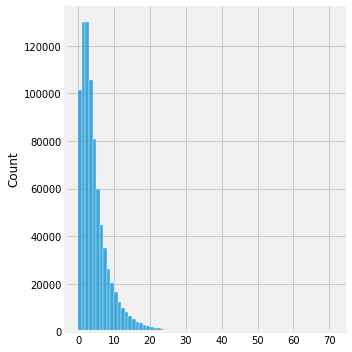

In [8]:
#- 데이터가 뉴스이므로, 원문의 앞 문장일수록 ext_sum(추출요약)에 포함될 확률이 높음
extractives = []
for extractive_idxes in news['extractive'].values:
    extractives += extractive_idxes

sns.displot(extractives, binwidth=1)  

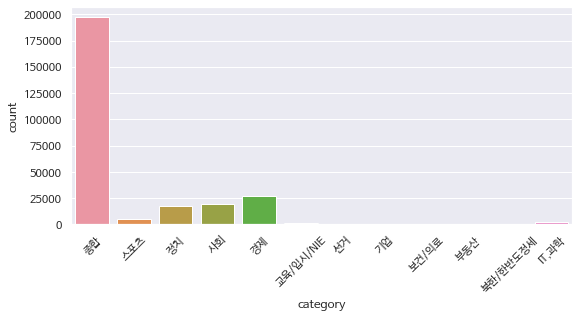

In [9]:
count_plot(news, 'category', figsize=(8,4))

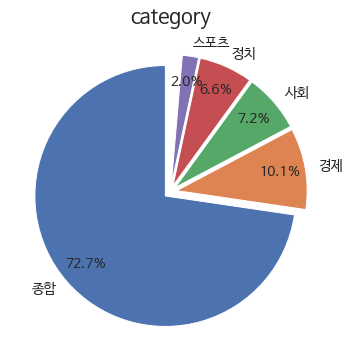

In [10]:
pie_plot(news,'category',True)

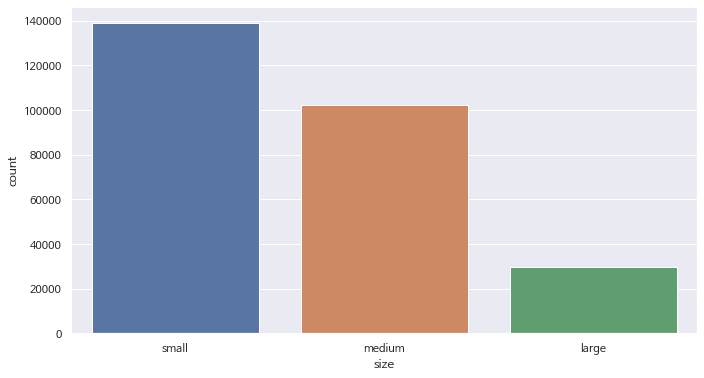

In [11]:
sns.countplot(x="size", data=news)
plt.show()

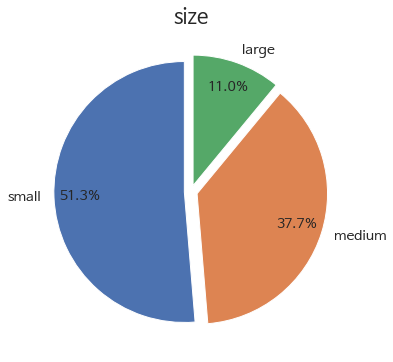

In [12]:
pie_plot(news,'size',True)

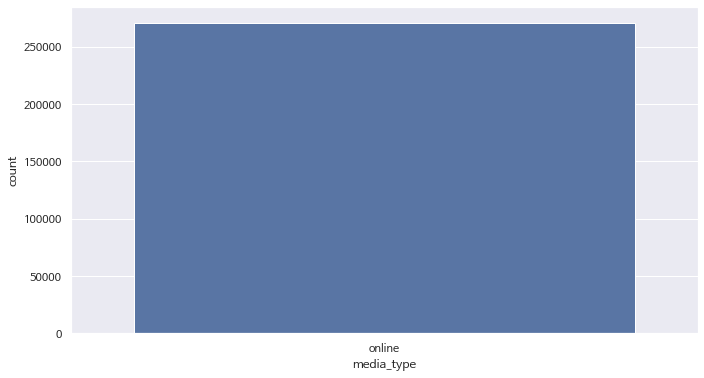

In [13]:
sns.countplot(x="media_type", data=news)
plt.show()

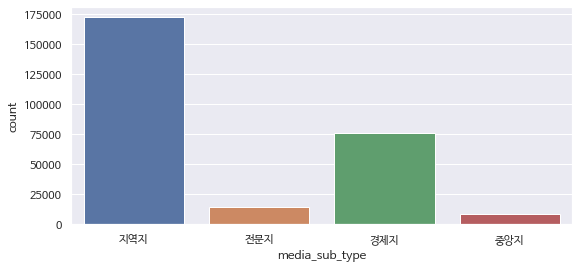

In [14]:
count_plot(news, 'media_sub_type', figsize=(8,4), rotation=False)

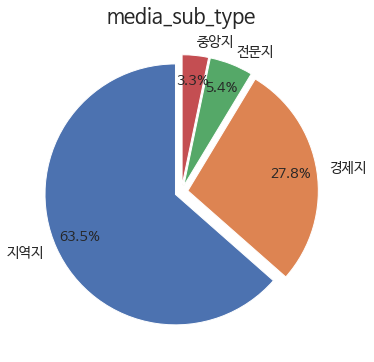

In [15]:
pie_plot(news,'media_sub_type',True)

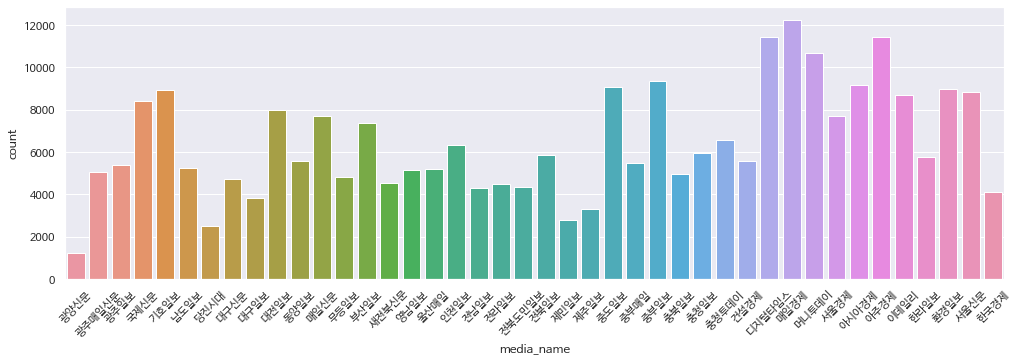

In [16]:
count_plot(news, 'media_name', figsize=(15,5))

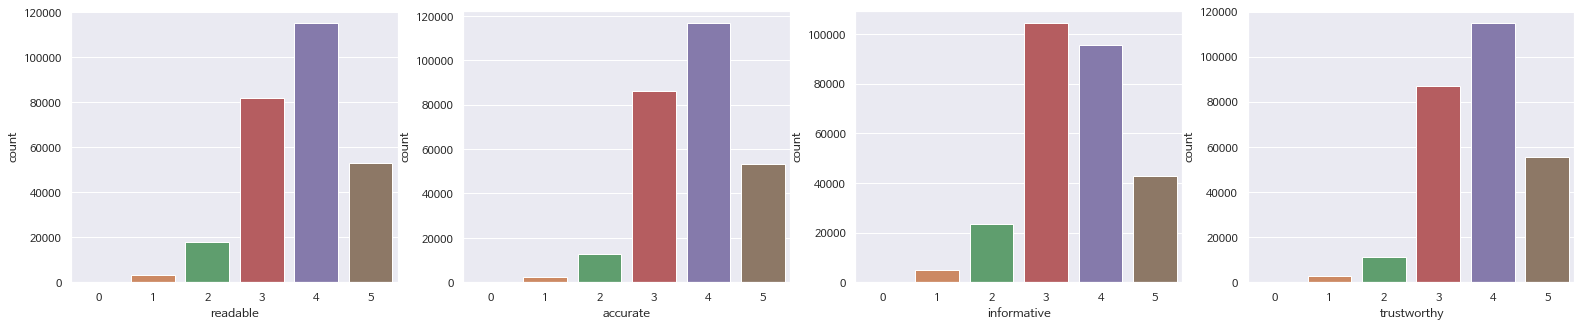

In [17]:
sns.set(rc = {'figure.figsize':(24,5)})
plt.rc('font', family='NanumBarunGothic') 

fig, axes = plt.subplots(1,4)

sns.countplot(x="readable", data=news, ax = axes[0])
sns.countplot(x="accurate", data=news, ax = axes[1])
sns.countplot(x="informative", data=news, ax = axes[2])
sns.countplot(x="trustworthy", data=news, ax = axes[3])


plt.show()

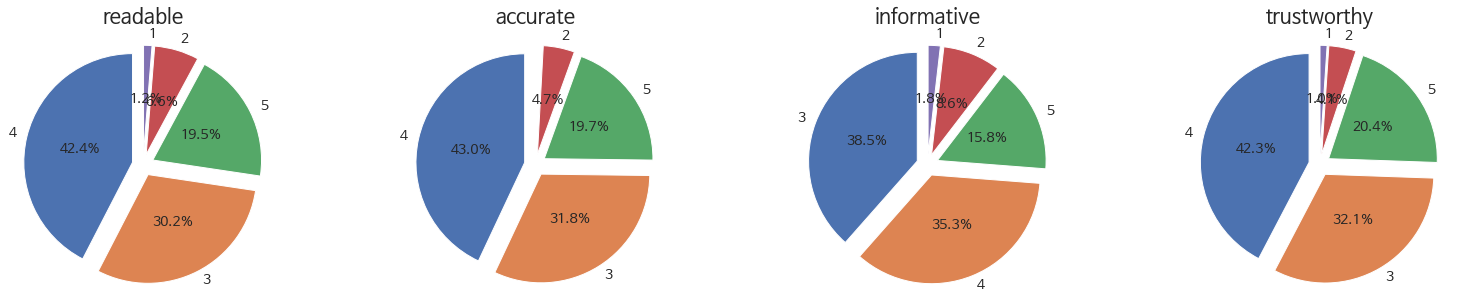

In [18]:
sns.set(rc = {'figure.figsize':(24,5)})
plt.rc('font', family='NanumBarunGothic') 

fig, axes = plt.subplots(1,4)

lst = ['readable','accurate','informative','trustworthy']
for i, col in enumerate(lst):
    
    cnt = news[col].value_counts() 
    prob = cnt / cnt.sum()
    prob = prob[prob>0.01]
 
    axes[i].pie(prob.values,labels = prob.index.values, autopct='%.1f%%', pctdistance=0.5, explode=[0.1]*len(prob),textprops={'fontsize': 14}, startangle=90)
    axes[i].set_title(col, fontsize=20)
plt.show()


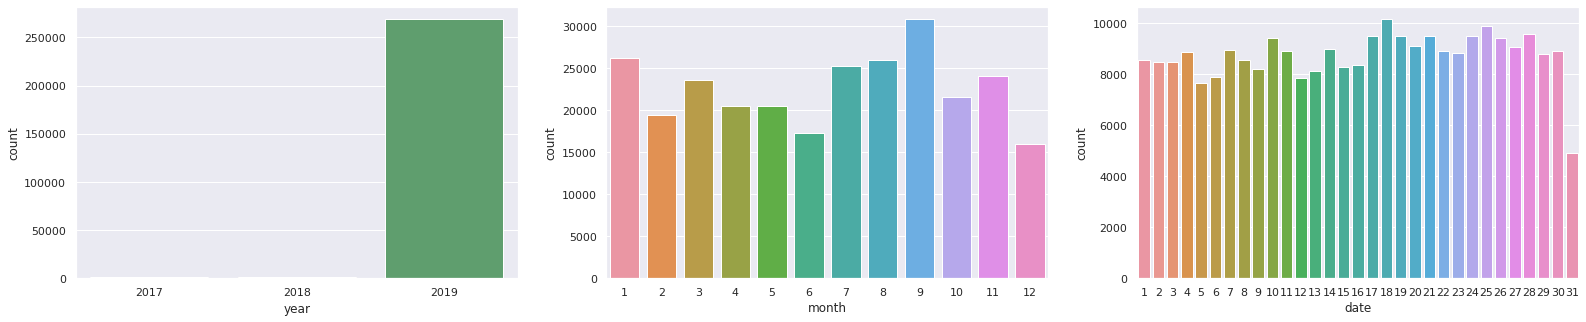

In [19]:
sns.set(rc = {'figure.figsize':(24,5)})
fig, axes = plt.subplots(ncols=3)

sns.countplot(x="year", data=news,ax=axes[0])
sns.countplot(x="month", data=news, ax=axes[1])
sns.countplot(x="date", data=news, ax=axes[2])

plt.show()

In [20]:
print('<News char_count of size small>\n',news[news['size']=='small']['char_count'].describe()) #- size small의 평균 char_count : 833
print('\n\n<News char_count of size medium>\n',news[news['size']=='medium']['char_count'].describe()) #- size medium의 평균 char_count : 1204
print('\n\n<News char_count of size large>\n',news[news['size']=='large']['char_count'].describe()) #- size large의 평균 char_count : 1694

<News char_count of size small>
 count    139109.000000
mean        832.504015
std          86.243796
min         700.000000
25%         757.000000
50%         824.000000
75%         904.000000
max         999.000000
Name: char_count, dtype: float64


<News char_count of size medium>
 count    102189.000000
mean       1204.226502
std         139.517880
min        1000.000000
25%        1083.000000
50%        1184.000000
75%        1315.000000
max        1499.000000
Name: char_count, dtype: float64


<News char_count of size large>
 count    29795.000000
mean      1693.970465
std        138.881465
min       1500.000000
25%       1574.000000
50%       1667.000000
75%       1800.000000
max       2000.000000
Name: char_count, dtype: float64


In [21]:
news['size'].value_counts()

small     139109
medium    102189
large      29795
Name: size, dtype: int64

In [22]:
news['char_count'].groupby(news['size']).mean()

size
large     1693.970465
medium    1204.226502
small      832.504015
Name: char_count, dtype: float64

In [23]:
news.head()

,id,category,media_type,media_sub_type,media_name,size,char_count,publish_date,title,text,...,origin,ext_sum,abs_sum,readable,accurate,informative,trustworthy,year,month,date
1,290741778,종합,online,지역지,광양신문,small,927,2018-01-05 18:54:55,"논 타작물 재배, 2월 말까지 신청하세요","[[{'index': 0, 'sentence': 'ha당 조사료 400만원…작물별 ...",...,"[ha당 조사료 400만원…작물별 차등 지원, 이성훈 sinawi@hanmail.n...",[전라남도가 쌀 과잉문제를 근본적으로 해결하기 위해 올해부터 시행하는 쌀 생산조정제...,전라남도가 쌀 과잉문제를 근본적으로 해결하기 위해 올해부터 벼를 심었던 논에 벼 대...,4,3,3,3,2018,1,5
2,290741792,종합,online,지역지,광양신문,small,764,2018-01-05 18:53:20,"여수시, 컬러빌리지 마무리...‘색채와 빛’도시 완성","[[{'index': 0, 'sentence': '8억 투입, 고소천사벽화·자산마을...",...,"[8억 투입, 고소천사벽화·자산마을에 색채 입혀, 이성훈 sinawi@hanmail...",[여수시는 원도심 일대에서 추진된 컬러빌리지 사업을 지난해 말 마무리하며 색채와 빛...,여수시는 컬러빌리지 사업에 8억원을 투입하여 ‘색채와 빛’ 도시를 완성하여 고소천사...,4,4,5,4,2018,1,5
3,290741793,스포츠,online,지역지,광양신문,medium,1066,2018-01-05 18:52:15,“새해 정기 받고 올해는 반드시 일내자!”,"[[{'index': 0, 'sentence': '전남드래곤즈 해맞이 다짐…선수 영...",...,"[전남드래곤즈 해맞이 다짐…선수 영입 활발, 이성훈 sinawi@hanmail.ne...",[임직원과 선수단 모두는 이날 구봉산 정상에 올라 일출을 보며 2018년 구단 목표...,전남드래곤즈 임직원과 선수단이 4일 구봉산 정상에 올라 일출을 보며 2018년 구단...,4,4,4,4,2018,1,5
4,290741794,정치,online,지역지,광양신문,small,746,2018-01-05 18:50:17,"농업인 역량 강화, 새해 실용교육 실시","[[{'index': 0, 'sentence': '11~24일, 매실·감·참다래 등...",...,"[11~24일, 매실·감·참다래 등 지역특화작목, 이성훈 sinawi@hanmail...",[광양시는 오는 11일부터 24일까지 농업인교육관과 읍면동 회의실에서 농업인 105...,"광양시는 농업인들의 경쟁력을 높이고, 소득안정을 위해 매실·감·참다래 등 지역특화작...",4,4,5,4,2018,1,5
5,290741797,종합,online,지역지,광양신문,small,978,2018-01-05 18:52:36,타이완 크루즈관광객 4천여명‘전남’온다,"[[{'index': 0, 'sentence': '홍콩 크루즈선사‘아쿠아리우스’ 4...",...,"[홍콩 크루즈선사‘아쿠아리우스’ 4, 6월 여수항 입항, 이성훈 sinawi@han...",[전라남도는 올해 4월과 6월 홍콩 크루즈선사 스타크루즈의 5만톤급‘아쿠아리우스’호...,올해 4월과 6월 두 차례에 걸쳐 타이완의 크루즈 관광객 4000여명이 여수에 입항...,4,4,4,4,2018,1,5


In [24]:
df = news[['title','origin','ext_sum','abs_sum','size','char_count','readable','accurate','informative','trustworthy','media_sub_type']]

df.head()

,title,origin,ext_sum,abs_sum,size,char_count,readable,accurate,informative,trustworthy,media_sub_type
1,"논 타작물 재배, 2월 말까지 신청하세요","[ha당 조사료 400만원…작물별 차등 지원, 이성훈 sinawi@hanmail.n...",[전라남도가 쌀 과잉문제를 근본적으로 해결하기 위해 올해부터 시행하는 쌀 생산조정제...,전라남도가 쌀 과잉문제를 근본적으로 해결하기 위해 올해부터 벼를 심었던 논에 벼 대...,small,927,4,3,3,3,지역지
2,"여수시, 컬러빌리지 마무리...‘색채와 빛’도시 완성","[8억 투입, 고소천사벽화·자산마을에 색채 입혀, 이성훈 sinawi@hanmail...",[여수시는 원도심 일대에서 추진된 컬러빌리지 사업을 지난해 말 마무리하며 색채와 빛...,여수시는 컬러빌리지 사업에 8억원을 투입하여 ‘색채와 빛’ 도시를 완성하여 고소천사...,small,764,4,4,5,4,지역지
3,“새해 정기 받고 올해는 반드시 일내자!”,"[전남드래곤즈 해맞이 다짐…선수 영입 활발, 이성훈 sinawi@hanmail.ne...",[임직원과 선수단 모두는 이날 구봉산 정상에 올라 일출을 보며 2018년 구단 목표...,전남드래곤즈 임직원과 선수단이 4일 구봉산 정상에 올라 일출을 보며 2018년 구단...,medium,1066,4,4,4,4,지역지
4,"농업인 역량 강화, 새해 실용교육 실시","[11~24일, 매실·감·참다래 등 지역특화작목, 이성훈 sinawi@hanmail...",[광양시는 오는 11일부터 24일까지 농업인교육관과 읍면동 회의실에서 농업인 105...,"광양시는 농업인들의 경쟁력을 높이고, 소득안정을 위해 매실·감·참다래 등 지역특화작...",small,746,4,4,5,4,지역지
5,타이완 크루즈관광객 4천여명‘전남’온다,"[홍콩 크루즈선사‘아쿠아리우스’ 4, 6월 여수항 입항, 이성훈 sinawi@han...",[전라남도는 올해 4월과 6월 홍콩 크루즈선사 스타크루즈의 5만톤급‘아쿠아리우스’호...,올해 4월과 6월 두 차례에 걸쳐 타이완의 크루즈 관광객 4000여명이 여수에 입항...,small,978,4,4,4,4,지역지


In [25]:
def only_sen(x):
    '''
    원문에서 마침표로 끝나는 문장과 마침표가 없는 구문을 구분하여 추출하는 함수
    '''
    sentence = []
    phrase = []
    cnt = 0
    
    for i in x:
        if i[-1] != '.':
            cnt += 1
            phrase.append(i)
        else:
            sentence.append(i)
    return cnt, phrase, sentence

In [26]:
%%time
df['tmp'] = df.origin.apply(only_sen) 
df['cnt'] = df.tmp.map(lambda x: x[0])
df['phrase'] = df.tmp.map(lambda x: x[1])
df['sentence'] = df.tmp.map(lambda x: x[2])

CPU times: user 3.33 s, sys: 264 ms, total: 3.59 s
Wall time: 3.59 s


In [27]:
#- 원문리스트의 요소 중 마침표로 끝나지 않는 구문의 개수
df['cnt'].describe()

count    271093.000000
mean          1.640275
std           2.073814
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          97.000000
Name: cnt, dtype: float64

In [28]:
#- 원문리스트의 요소 중 마침표로 끝나지 않는 구문
df['phrase']

1         [ha당 조사료 400만원…작물별 차등 지원, 이성훈 sinawi@hanmail.net]
2         [8억 투입, 고소천사벽화·자산마을에 색채 입혀, 이성훈 sinawi@hanmail...
3          [전남드래곤즈 해맞이 다짐…선수 영입 활발, 이성훈 sinawi@hanmail.net]
4         [11~24일, 매실·감·참다래 등 지역특화작목, 이성훈 sinawi@hanmail...
5         [홍콩 크루즈선사‘아쿠아리우스’ 4, 6월 여수항 입항, 이성훈 sinawi@han...
                                ...                        
271089                                                   []
271090                                                   []
271091                                                   []
271092                                         [[ 김보형 기자 ]]
271093                                         [[ 박동휘 기자 ]]
Name: phrase, Length: 271093, dtype: object

In [29]:
df['original_text'] = df.sentence.map(lambda x: ' '.join(x))
df['original_text']

1         전라남도가 쌀 과잉문제를 근본적으로 해결하기 위해 올해부터 시행하는 쌀 생산조정제를...
2         여수시는 원도심 일대에서 추진된 컬러빌리지 사업을 지난해 말 마무리하며 색채와 빛의...
3         전남드래곤즈(사장 신승재)는 지난 4일 구봉산 해맞이 행사를 통해 새해 각오를 다졌...
4         광양시는 오는 11일부터 24일까지 농업인교육관과 읍면동 회의실에서 농업인 1050...
5         타이완의 크루즈관광객 4000여명이 올해 두 차례에 걸쳐 여수에 입항한다. 전라남도...
                                ...                        
271089    [ 노유정 기자 ] 조양호 한진그룹 회장의 갑작스런 타계 소식이 전해진 8일 오전,...
271090    ] 조양호 한진그룹 회장이 타계하자 재계는 일제히 추모성명을 냈다. 전국경제인연합회...
271091    [ 김익환 기자 ] 조양호 한진그룹 회장이 타계하면서 그의 재산을 물려받을 장남 조...
271092    조양호 한진그룹 회장이 8일 타계하면서 그의 장남인 조원태 대한항공 사장(44)의 ...
271093    국방부가 8일 상반기 군 장성 인사를 단행했다. 한국군 주도의 한·미 연합작전 수행...
Name: original_text, Length: 271093, dtype: object

In [30]:
%%time
df['tmp'] = df.ext_sum.apply(only_sen) 
df['cnt'] = df.tmp.map(lambda x: x[0])
df['phrase'] = df.tmp.map(lambda x: x[1])
df['sentence'] = df.tmp.map(lambda x: x[2])

CPU times: user 2.36 s, sys: 79.9 ms, total: 2.44 s
Wall time: 2.44 s


In [31]:
df['cnt'].describe()

count    271093.000000
mean          0.017086
std           0.137171
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           3.000000
Name: cnt, dtype: float64

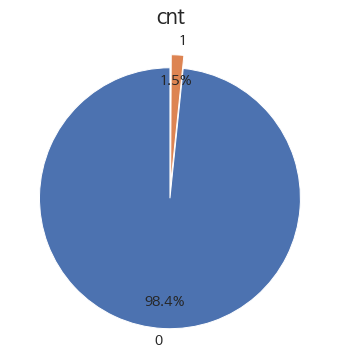

In [32]:
pie_plot(df,'cnt',True)

In [33]:
df = df[df['cnt'] == 0]

In [34]:
# 텍스트 전처리
import re

def preprocess_text(text):
    
    #- html 처리
    text = text.replace(u'\xa0', u'')  
    
    #- 이메일 처리 (이메일 형식과 일치하면 공백으로 대체)
    pattern = '([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)'
    text = re.sub(pattern=pattern, repl="", string=text)
    
    #- url 처리
    url = re.compile(r'https?://\S+|www\.\S+')
    url.sub(r'',text)
    
    #- 여러개의 공백은 하나의 공백으로
    text = re.sub(' +', ' ', text) 
    
    #- [ ~ ] 처리
    text = re.sub(r'\[.+\]', " ", text)
    
    #- 불필요한 기호 공백으로 대체
    #- text = re.sub('[^가-힣a-zA-Z0-9,.?!-~%]+'," ", text)
    text = re.sub(r'[“”]+','"',text)
    text = re.sub(r'[^ㄱ-ㅎ가-힣a-zA-Z0-9.,·\-\'\"!?~%()]+'," ", text)
    
    #- 여러개의 공백은 하나의 공백으로
    text = re.sub(' +', ' ', text) 
    
    #- 양쪽 공백 제거
    text = text.strip() 
    
    return text

In [37]:
%%time
#- 원문
df['original_text'] = df['original_text'].apply(preprocess_text)

#- 추출요약문
df['ext_sum_lst'] = df['ext_sum'].apply(lambda x: [preprocess_text(i) for i in x])
df['ext_sum'] = df['ext_sum_lst'].map(lambda x: ' '.join(x))
df['ext_char_cnt'] = df['ext_sum'].map(lambda x: len(x))

#- 생성요약문
df['summary'] = df['abs_sum'].map(lambda x : preprocess_text(x))
df['sum_char_cnt'] = df['summary'].map(lambda x: len(x))

CPU times: user 1min 41s, sys: 753 ms, total: 1min 42s
Wall time: 1min 42s


In [38]:
#- null 데이터 제거 (6개)
condition = (df['char_count'] == 0) | (df['ext_char_cnt'] == 0) | (df['sum_char_cnt'] == 0)
df = df[~condition]

In [39]:
#- 사용할 컬럼만 추출하기
text = ['title', 'original_text','ext_sum','ext_sum_lst','summary']
length = ['size','char_count','sum_char_cnt','ext_char_cnt']
score = ['readable','accurate','informative','trustworthy']
extra = ['media_sub_type']

df = df[text + length + score + extra]

In [42]:
df.to_csv('aihub_eda.csv', index = False)